# Setup Ollama

In [ ]:
# Install Ollama
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [26]:
# Start Ollama server as background process
import subprocess
import time

def start_ollama_server():
    subprocess.Popen(['ollama', 'serve'])
    time.sleep(3)  # wait for server to start
    print('Ollama server launched successfully!')

start_ollama_server()

Ollama server launched successfully!


In [ ]:
# Pull the LLM model
!ollama pull llama3.2:3b
!ollama pull gpt-oss:20b
!ollama list


NAME           ID              SIZE     MODIFIED               
gpt-oss:20b    17052f91a42e    13 GB    Less than a second ago    


# Clone repository and install libraries

In [4]:
# Clone the DataAgent repository
!git clone -b python --single-branch https://github.com/Palpal16/DataAgent.git

Cloning into 'DataAgent'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 225 (delta 64), reused 200 (delta 42), pack-reused 0 (from 0)
Receiving objects: 100% (225/225), 3.84 MiB | 12.06 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [5]:
# Change to DataAgent directory
import os
os.chdir('/content/DataAgent')

In [15]:
# Install required dependencies
!pip install -q langgraph langchain-ollama duckdb pandas pyarrow matplotlib
!pip install -q arize-phoenix opentelemetry-api opentelemetry-sdk
!pip install -q langchain-core langchain-community

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [7]:
import os
import json
from Agent.utils import *
from Agent.data_agent import SalesDataAgent

<class 'Exception'>
<module 'langgraph.version' from '/usr/local/lib/python3.12/dist-packages/langgraph/version.py'>


# Run agent on a dataset with LLM of choice

In [ ]:
llm = "gpt-oss:20b" #It needs to be downloaded from ollama

In [ ]:
agent = SalesDataAgent(
    enable_tracing=True,
    phoenix_endpoint="http://localhost:6006/v1/traces",
    project_name="evaluating-agent",
    model=llm
)

Server is running locally
Ollama is running locally


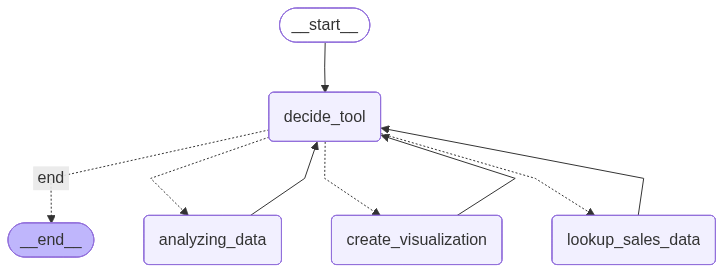

In [36]:
agent.check_model()
agent.draw_graph()

In [38]:
PREFIX = 'gpt'
DATASET_FILE_PATH = f"evaluation/{PREFIX}_dataset.json"
if os.path.exists(DATASET_FILE_PATH):
    with open(DATASET_FILE_PATH, 'r') as f:
        dataset = json.load(f)

for i in range(len(dataset)):
    if (dataset[i].get('gen_sql') and dataset[i].get('gen_data')):
        print(f'\nSkipping question {i+1}/{len(dataset)} as generated results were already added.')
        continue
    print(f"------- Question {i+1}/{len(dataset)} -------")

    ret = agent.run(dataset[i]['prompt'], only_lookup=True)
    dataset[i]['gen_sql']=ret['sql_query']
    dataset[i]['gen_data']=ret['data']

with open(DATASET_FILE_PATH, 'w') as f:
    json.dump(dataset, f, indent=2)

------- Question 1/21 -------
Checking the model can run locally
Server is running locally
Ollama is running locally
[Agent] Running only lookup_sales_data
Generated SQL Query:
 SELECT DATE_TRUNC('month', Sold_Date) AS month_start,
       SUM(Total_Sale_Value) AS total_revenue,
       SUM(Qty_Sold) AS total_units
FROM sales
WHERE Sold_Date >= '2023-01-01' AND Sold_Date < '2024-01-01'
GROUP BY month_start
ORDER BY month_start ASC;
------- Question 2/21 -------
[Agent] Running only lookup_sales_data
Generated SQL Query:
 SELECT SKU_Coded,
       SUM(Qty_Sold) AS total_units,
       SUM(Total_Sale_Value) AS total_revenue
FROM sales
GROUP BY SKU_Coded
ORDER BY total_units DESC,
         total_revenue DESC,
         SKU_Coded ASC
LIMIT 20;
------- Question 3/21 -------
[Agent] Running only lookup_sales_data
Generated SQL Query:
 SELECT
    Product_Class_Code,
    SUM(Total_Sale_Value) AS total_revenue,
    SUM(Qty_Sold) AS total_units
FROM
    sales
WHERE
    CAST(Sold_Date AS VARCHAR) LIKE

In [39]:
from google.colab import files
files.download(DATASET_FILE_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Run agent using LLM as a judge

In [ ]:
agent = SalesDataAgent(
    enable_tracing=True,
    phoenix_endpoint="http://localhost:6006/v1/traces",
    project_name="evaluating-agent",
    model="llama3.2:3b"
)

In [ ]:
agent.check_model()
agent.draw_graph()

In [ ]:
result = agent.run("Which 20 SKUs had the highest total sales value in 2022?", no_vis=True)

# Evaluate the analysis
score, details  = judge_analysis(
    prompt=result.get("prompt", ""),
    sql_query=result.get("sql_query", ""),
    data=result.get("data", ""),
    analysis=result.get("answer", [""])[0],
    judge_model="gpt-oss:20b",
    ollama_url=agent.ollama_url
)

print(f"Score: {score:.2f}")
print(f"Correctness: {details['correctness']['score']} - {details['correctness']['reasoning']}")
print(f"Completeness: {details['completeness']['score']}")
print(f"Faithfulness: {details['faithfulness']['score']}")

if details['correctness']['issues']:
    print(f"Issues found: {details['correctness']['issues']}")

In [ ]:
#Best-of-n

PREFIX = 'claude'
DATASET_FILE_PATH = f"evaluation/{PREFIX}_dataset.json"
if os.path.exists(DATASET_FILE_PATH):
    with open(DATASET_FILE_PATH, 'r') as f:
        dataset = json.load(f)
i=4
data = dataset[i]

gt_rows = text_to_csv(data['gt_data'])
save_csv(gt_rows, data['gt_csv_path'])

ret, variance = best_of_n(
    agent, 
    data['prompt'],
    expected_csv=data['gt_csv_path'],
    csv_path=data['gen_csv_path'],
    n=3,
    temperature=[0.1,0.2], #Or also single values: 0.1
    judge_model = "gpt-oss:20b"
)